In [3]:
import sys
import subprocess

# Questo comando gestisce automaticamente gli spazi nel percorso
subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])

0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Stile grafici
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Caricamento
df = pd.read_csv('EnergyConsumption.csv') # Aggiusta il percorso se serve
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

# Feature Engineering base
df['hour'] = df.index.hour
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['year'] = df.index.year

# Creiamo la colonna 'Season' per i grafici
df['season'] = df['month'].apply(lambda x: 'Estate' if x in [6,7,8] else ('Inverno' if x in [12,1,2] else 'Altro'))

print("Dataset pronto. Range temporale:", df.index.min(), " - ", df.index.max())

Dataset pronto. Range temporale: 2004-10-01 01:00:00  -  2018-08-03 00:00:00


C:\Users\Rei Mici\AppData\Local\Temp\ipykernel_16344\524937669.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean(numeric_only=True)
C:\Users\Rei Mici\AppData\Local\Temp\ipykernel_16344\524937669.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df['AEP_MW'].resample('M').mean()


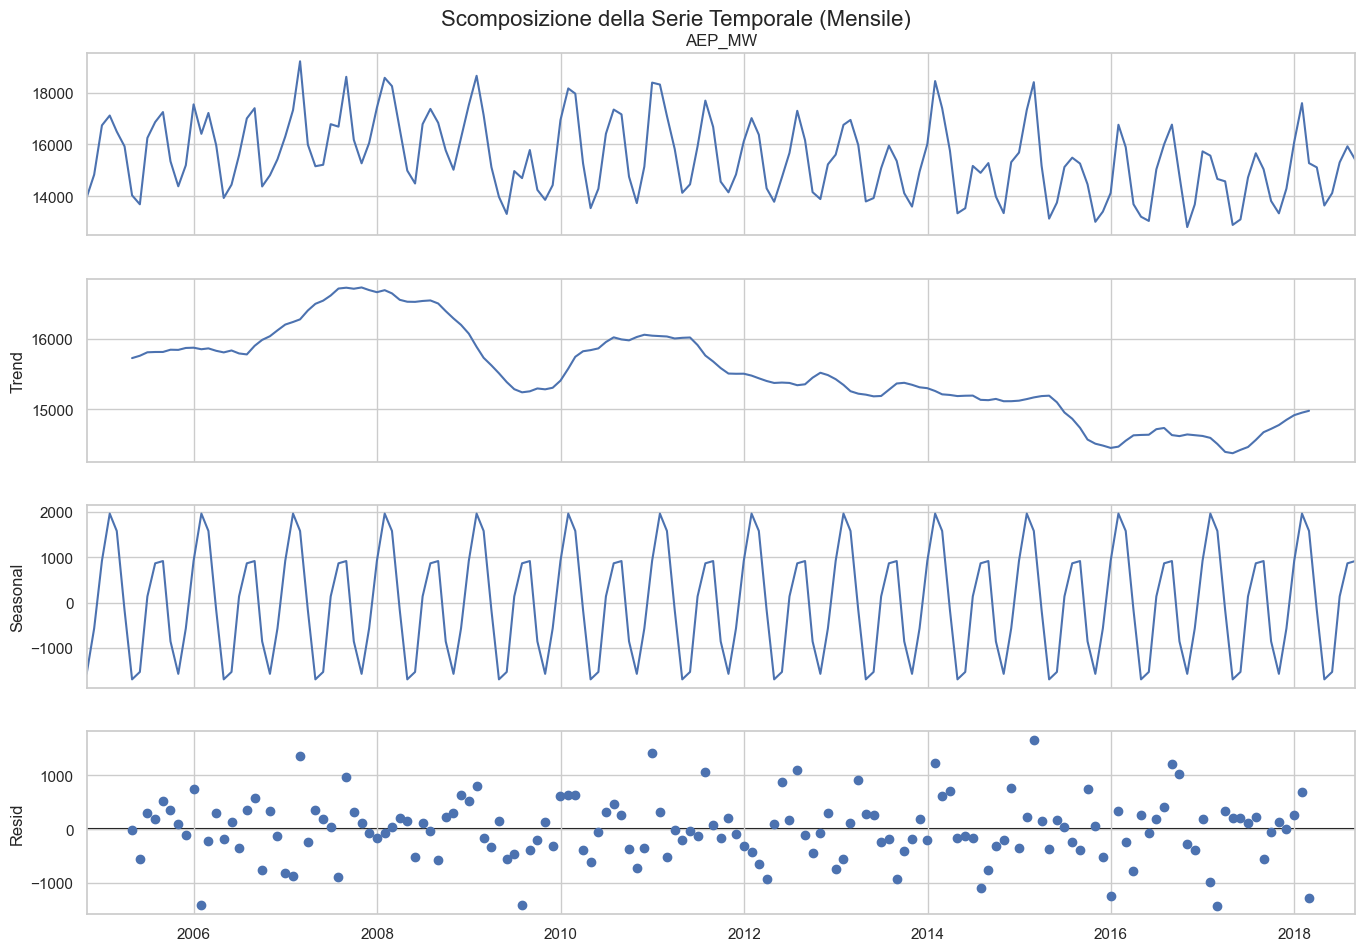

In [5]:
# Cella 2: Analisi Stagionalità (Corretta)

# Specifichiamo (numeric_only=True) per evitare che provi a fare la media del testo "Estate/Inverno"
df_monthly = df.resample('M').mean(numeric_only=True)

# Oppure, ancora meglio, selezioniamo solo la colonna che ci interessa prima di fare il resample
# Questo è il metodo più sicuro:
monthly_data = df['AEP_MW'].resample('M').mean()

# Decomposizione (Trend, Stagionalità, Residuo)
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)

# Plot
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Scomposizione della Serie Temporale (Mensile)', fontsize=16)
plt.show()

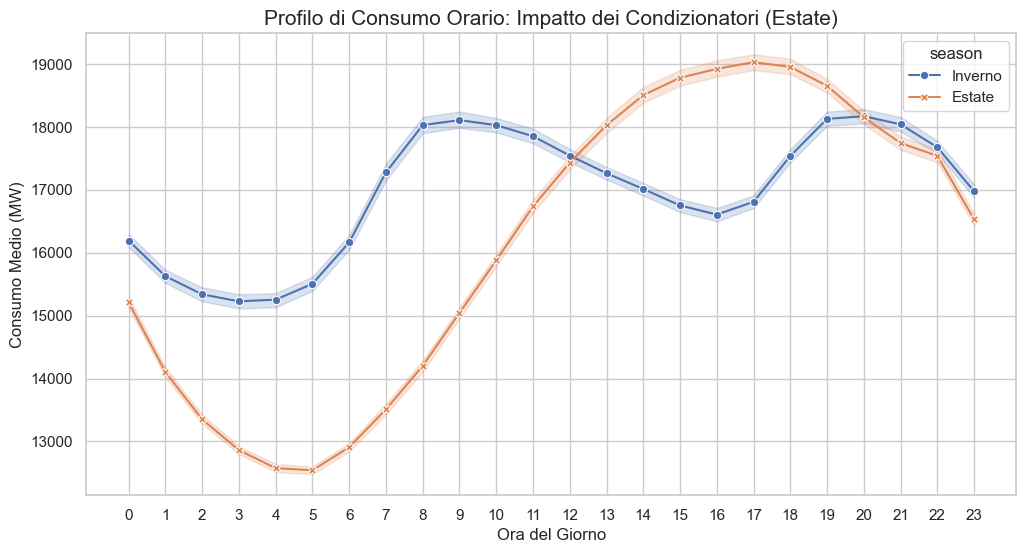

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df[df['season'].isin(['Estate', 'Inverno'])], 
             x='hour', y='AEP_MW', hue='season', style='season', markers=True, dashes=False)
plt.title('Profilo di Consumo Orario: Impatto dei Condizionatori (Estate)', fontsize=15)
plt.ylabel('Consumo Medio (MW)')
plt.xlabel('Ora del Giorno')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

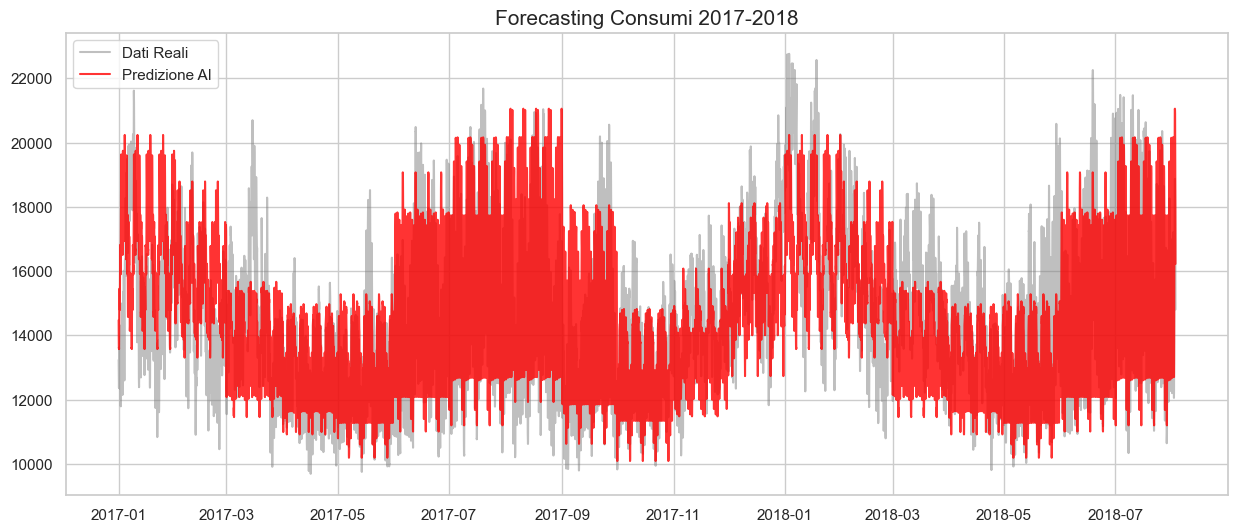

Errore Medio Assoluto (MAE): 1255.99 MW


In [7]:
# 1. Split Temporale
split_date = '2017-01-01'
train = df.loc[df.index < split_date].copy()
test = df.loc[df.index >= split_date].copy()

# 2. Addestramento (Random Forest)
features = ['hour', 'dayofweek', 'month', 'year']
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model.fit(train[features], train['AEP_MW'])

# 3. Predizione
test['prediction'] = model.predict(test[features])

# 4. Visualizzazione Risultati
plt.figure(figsize=(15, 6))
# Mostriamo solo l'ultimo periodo per chiarezza
plt.plot(test.index, test['AEP_MW'], label='Dati Reali', color='grey', alpha=0.5)
plt.plot(test.index, test['prediction'], label='Predizione AI', color='red', alpha=0.8)
plt.title('Forecasting Consumi 2017-2018', fontsize=15)
plt.legend()
plt.show()

# Metriche
error = mean_absolute_error(test['AEP_MW'], test['prediction'])
print(f"Errore Medio Assoluto (MAE): {error:.2f} MW")